# Using Seurat matrices

Here we will do a naive analysis on the raw matrices, without using the existing metadata



In [1]:
import scanpy as sc

In [29]:
ecs = sc.read_csv("files/4_extract/ecs.counts.tsv", delimiter="\t")
mcs = sc.read_csv("files/4_extract/mcs.counts.tsv", delimiter="\t")

In [30]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.1 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.7.0 leidenalg==0.8.1


In [33]:
ecs.var_names_make_unique()
mcs.var_names_make_unique()

In [35]:
print(ecs)
print(mcs)

AnnData object with n_obs × n_vars = 711 × 788
AnnData object with n_obs × n_vars = 589 × 789


normalizing counts per cell
    finished (0:00:00)


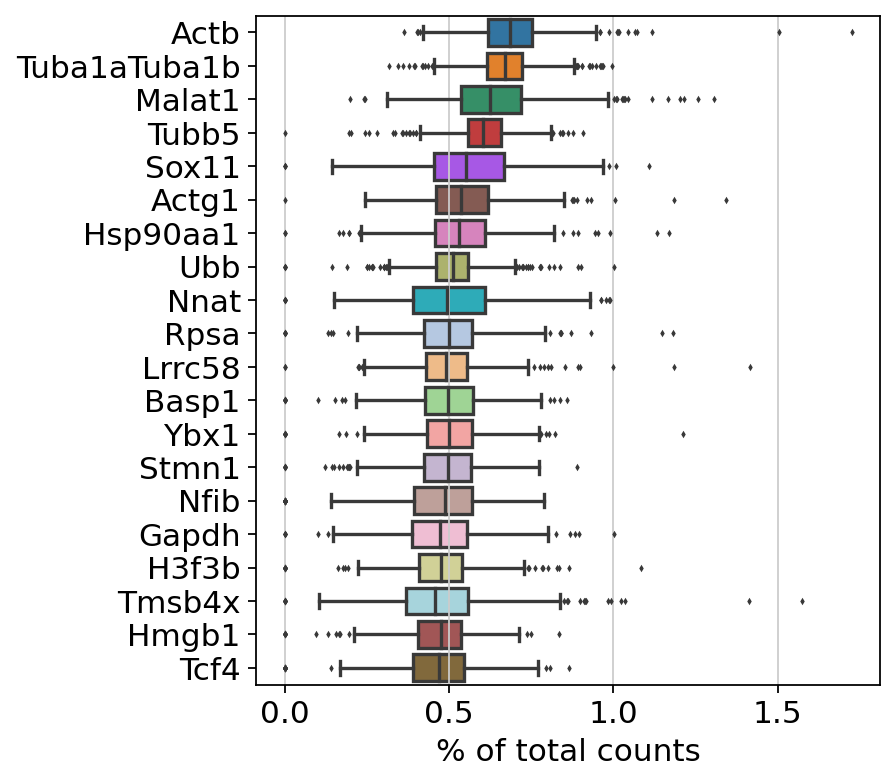

In [36]:
sc.pl.highest_expr_genes(ecs, n_top=20, )

normalizing counts per cell
    finished (0:00:00)


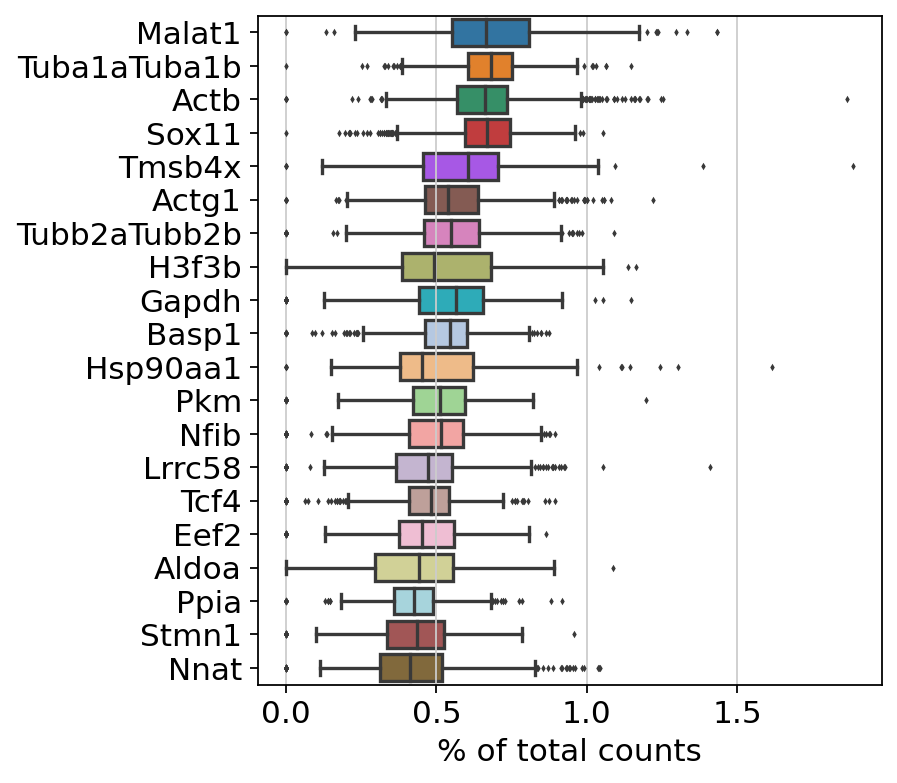

In [37]:
sc.pl.highest_expr_genes(mcs, n_top=20, )

## Basic filtering

Next time we should use the same parameters that Seurat used, but for now let's use the defaults

In [38]:
sc.pp.filter_cells(mcs, min_genes=200); sc.pp.filter_genes(mcs, min_cells=3)
sc.pp.filter_cells(ecs, min_genes=200); sc.pp.filter_genes(ecs, min_cells=3)

filtered out 6 cells that have less than 200 genes expressed
filtered out 1 genes that are detected in less than 3 cells
filtered out 6 cells that have less than 200 genes expressed


/home/tetris/repos/_work/_scrna/scRNA_2020_appiah/appiahenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [41]:
print(ecs)
print(mcs)

AnnData object with n_obs × n_vars = 705 × 788
    obs: 'n_genes'
    var: 'n_cells'
AnnData object with n_obs × n_vars = 583 × 788
    obs: 'n_genes'
    var: 'n_cells'


In [42]:
ecs.var['mt'] = ecs.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(ecs, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [43]:
mcs.var['mt'] = mcs.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(mcs, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

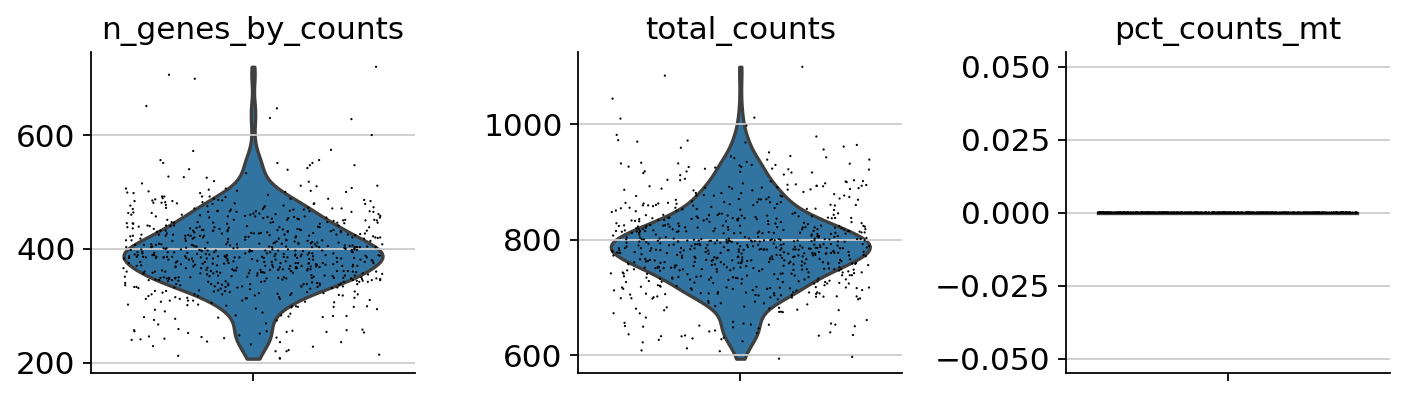

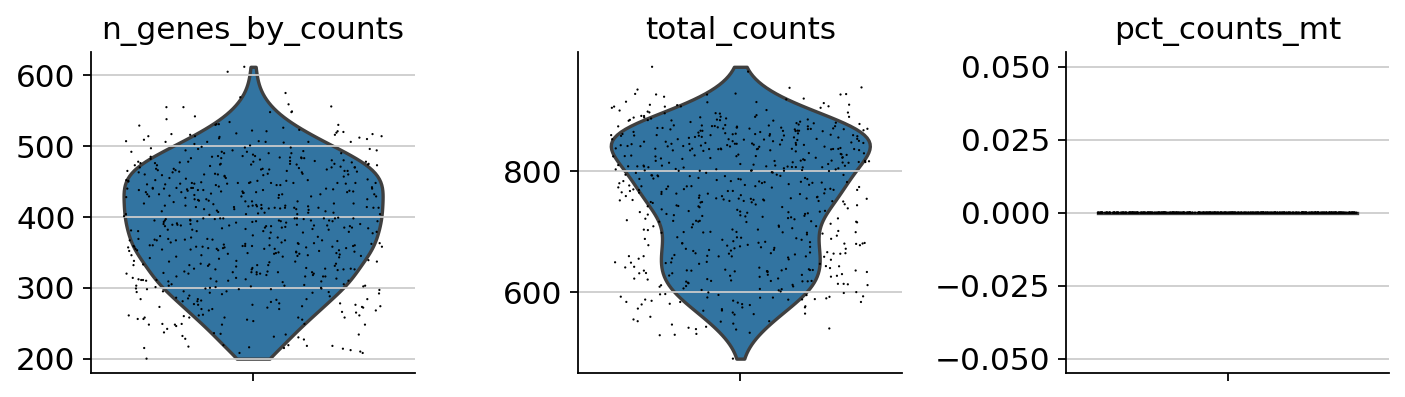

In [45]:
sc.pl.violin(ecs, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
sc.pl.violin(mcs, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)



No mitochondrial genes, and library size and nFeatures are around the same range

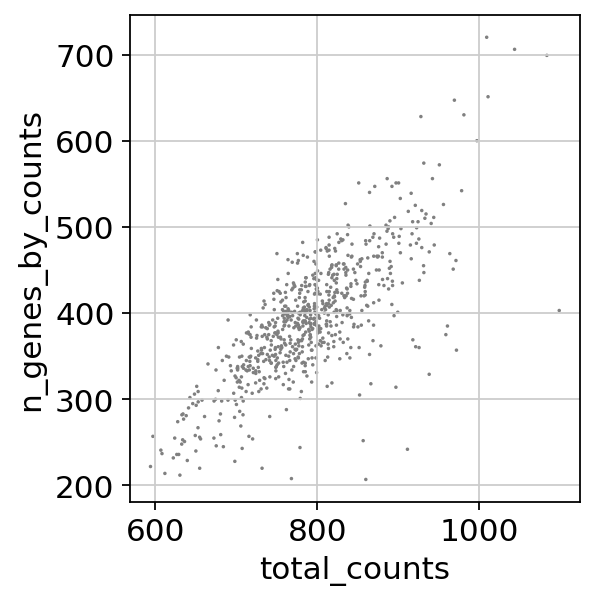

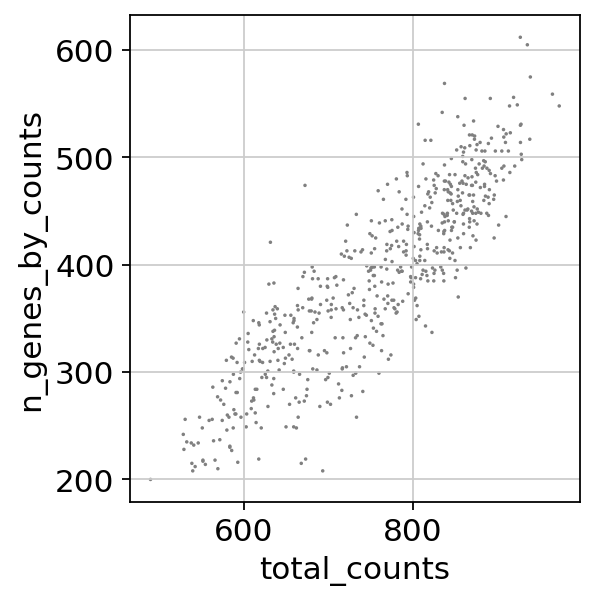

In [49]:
sc.pl.scatter(ecs, x='total_counts', y='n_genes_by_counts', size=10)
sc.pl.scatter(mcs, x='total_counts', y='n_genes_by_counts', size=10)

The ECS cells have libsizes > 6000, whereas MCS has a few less than that. ECS has only a few cells above 1000 so we can remove them to keep the upper range between these two datasets the same. We can also set an upper limit on the number of features to 600, where we would only lose 8 cells in the ECS.

In [50]:
ecs = ecs[ecs.obs.n_genes_by_counts <= 600, :]
mcs = mcs[mcs.obs.n_genes_by_counts <= 600, :]

/home/tetris/repos/_work/_scrna/scRNA_2020_appiah/appiahenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/tetris/repos/_work/_scrna/scRNA_2020_appiah/appiahenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [52]:
print(ecs); print(mcs)

View of AnnData object with n_obs × n_vars = 698 × 788
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
View of AnnData object with n_obs × n_vars = 581 × 788
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


We wont cut by lib size since we will control for that during the normalisation

In [53]:
sc.pp.normalize_total(ecs, target_sum=1e4)
sc.pp.normalize_total(mcs, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/home/tetris/repos/_work/_scrna/scRNA_2020_appiah/appiahenv/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [54]:
sc.pp.log1p(ecs)
sc.pp.log1p(mcs)

### Get the HVG

In [55]:
sc.pp.highly_variable_genes(ecs, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(mcs, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


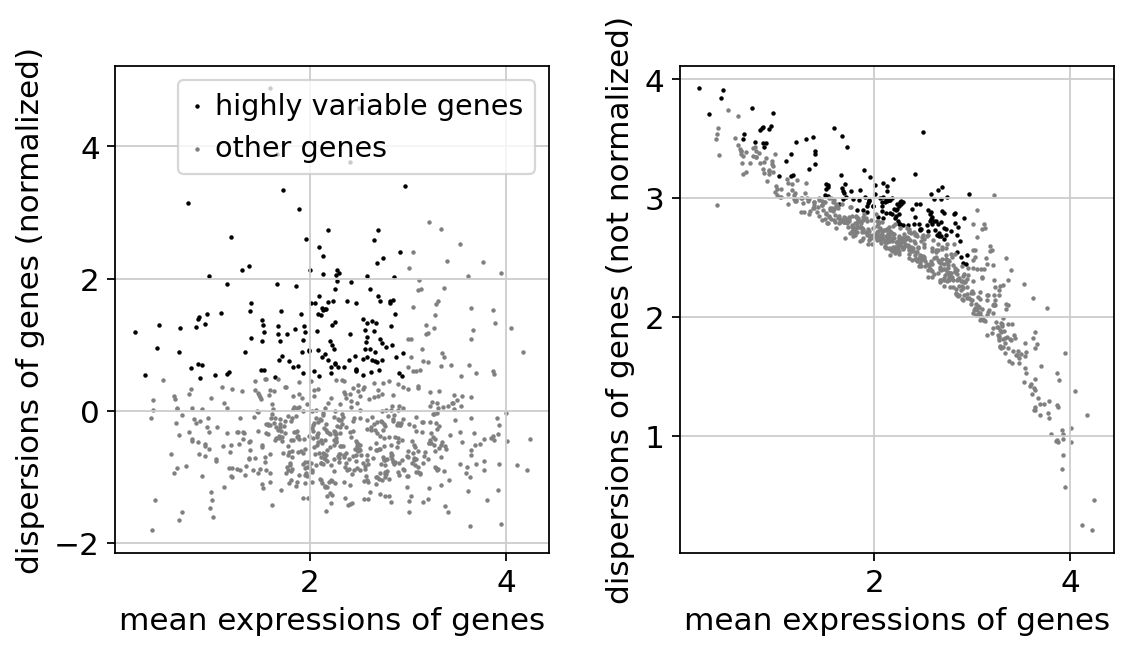

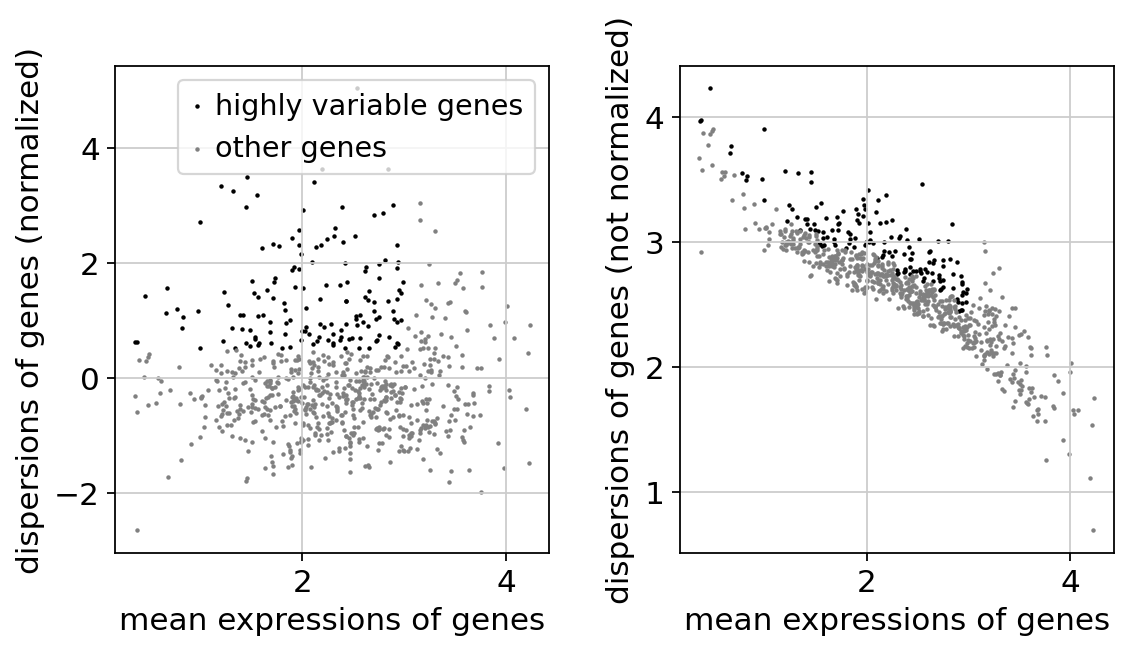

In [56]:
sc.pl.highly_variable_genes(ecs)
sc.pl.highly_variable_genes(mcs)

Wow, very few highly variable genes...

In [59]:
print("ECS:", ecs.var["highly_variable"].sum())
print("MCS:", mcs.var["highly_variable"].sum())

ECS: 156
MCS: 149


I'm not sure if that's enough to able to cluster on.... I may have to reduce HVG settings later on if no clustering can be found. For now let's proceed with this ~150 genes

In [60]:
ecs.raw = ecs
mcs.raw = mcs

In [61]:
ecs = ecs[:, ecs.var.highly_variable]
mcs = mcs[:, mcs.var.highly_variable]

/home/tetris/repos/_work/_scrna/scRNA_2020_appiah/appiahenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [62]:
sc.pp.regress_out(ecs, ['total_counts'])
sc.pp.regress_out(mcs, ['total_counts'])

regressing out ['total_counts']
    finished (0:00:00)
regressing out ['total_counts']
    finished (0:00:00)


In [63]:
sc.pp.scale(ecs, max_value=10)
sc.pp.scale(mcs, max_value=10)

## PCA

In [64]:
sc.tl.pca(ecs, svd_solver='arpack'); sc.tl.pca(mcs, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


/home/tetris/repos/_work/_scrna/scRNA_2020_appiah/appiahenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [81]:
# Look at the loadings
len(ecs.obsm["X_pca"])


698

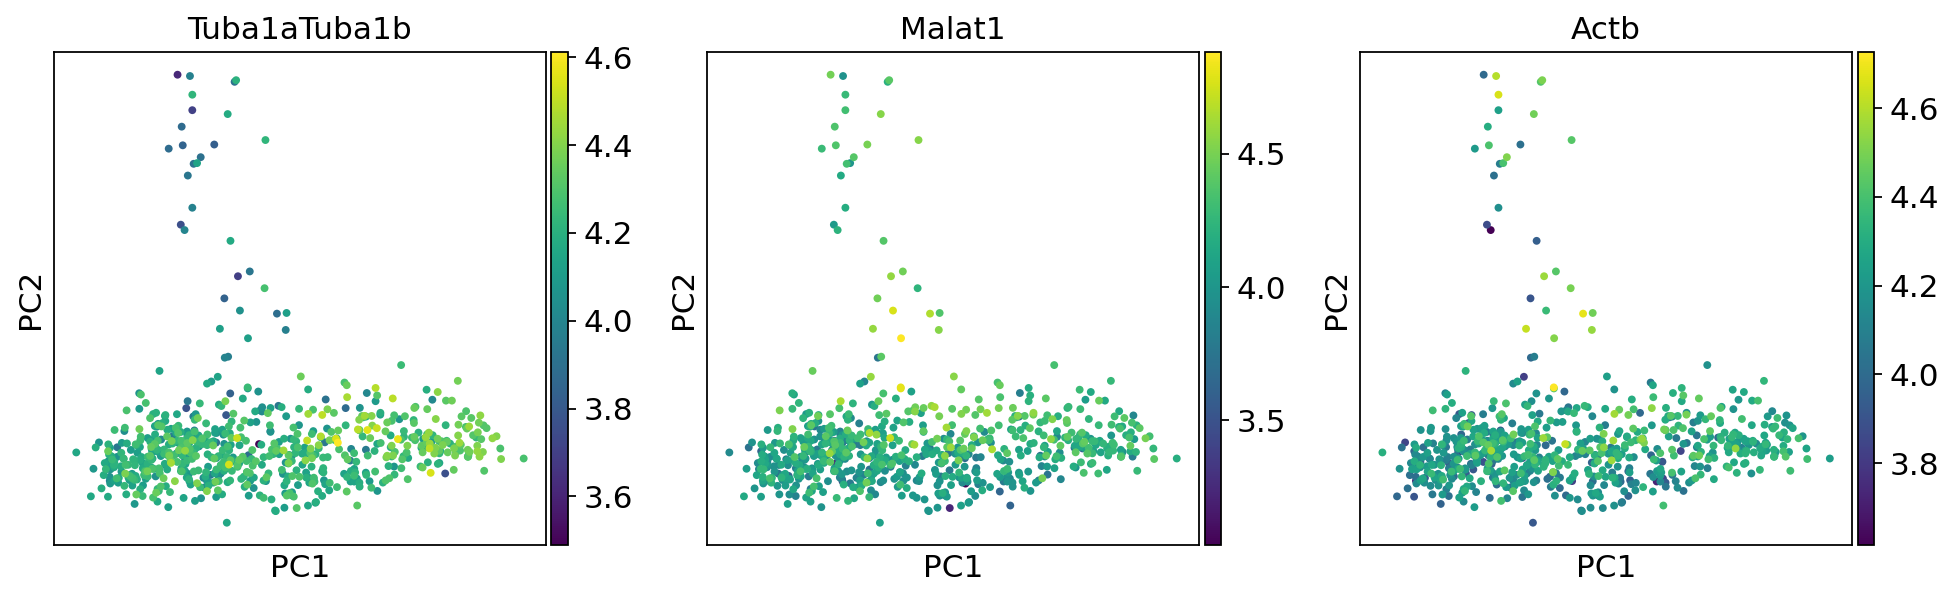

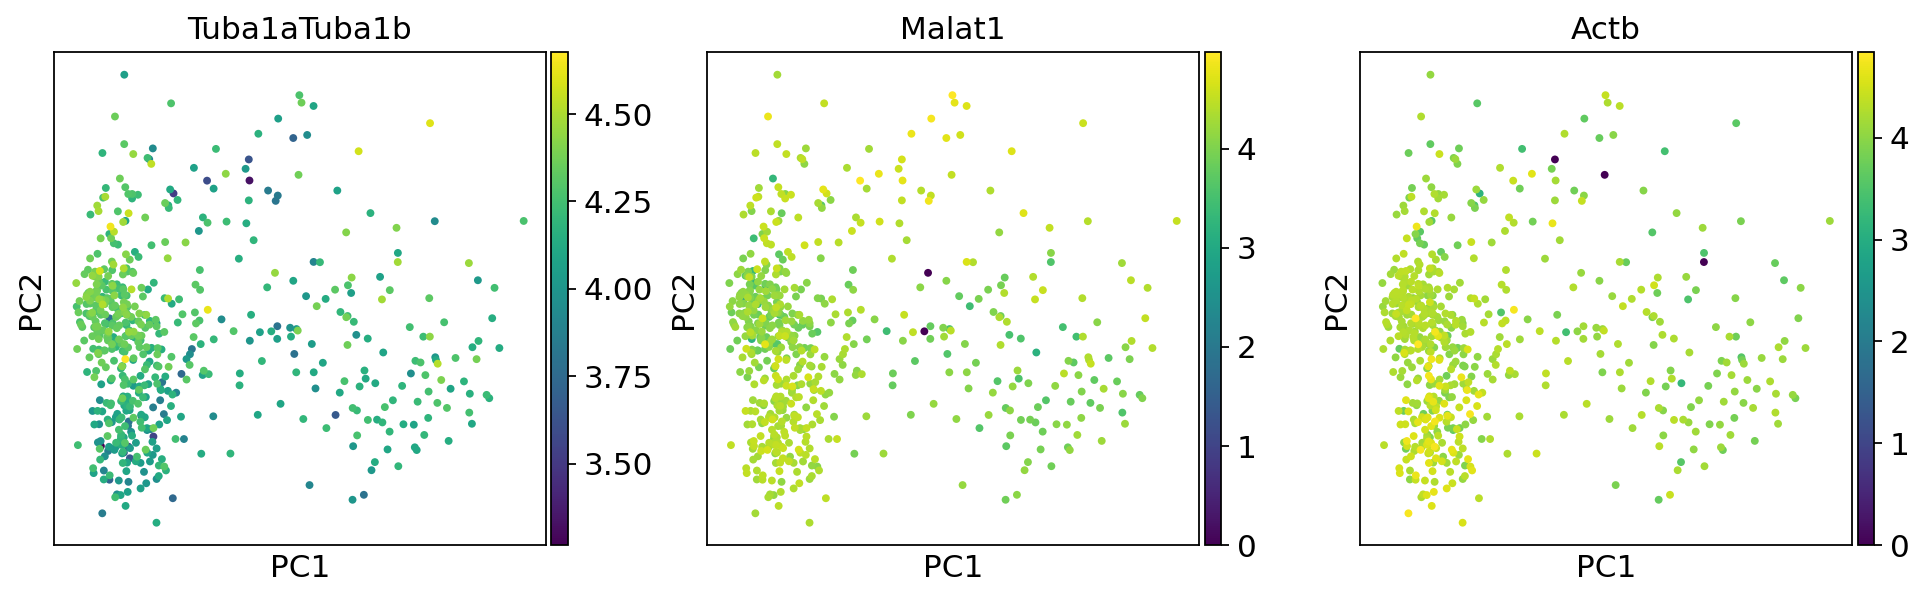

In [85]:
sc.pl.pca(ecs, color=["Tuba1aTuba1b", "Malat1", "Actb"], size=50);
sc.pl.pca(mcs, color=["Tuba1aTuba1b", "Malat1", "Actb"], size=50);

Not sure what to make of this, but the top 3 differentially expressed genes appear to have more complex seperation than just a PCA, so we will likely need to use UMAP

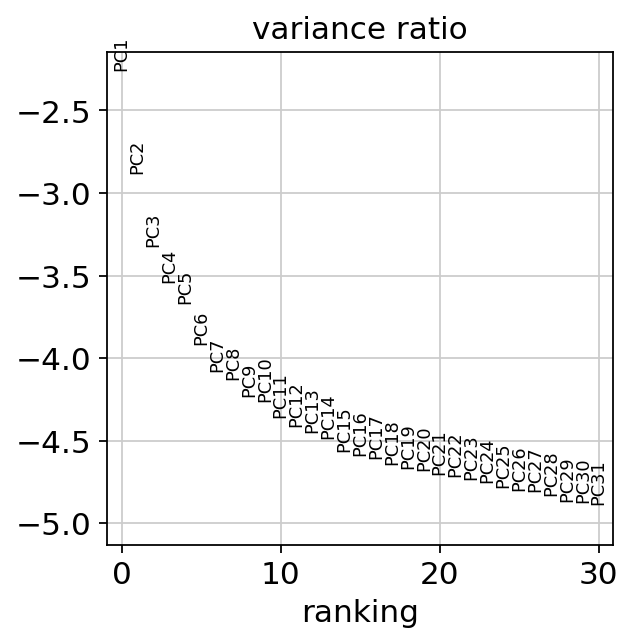

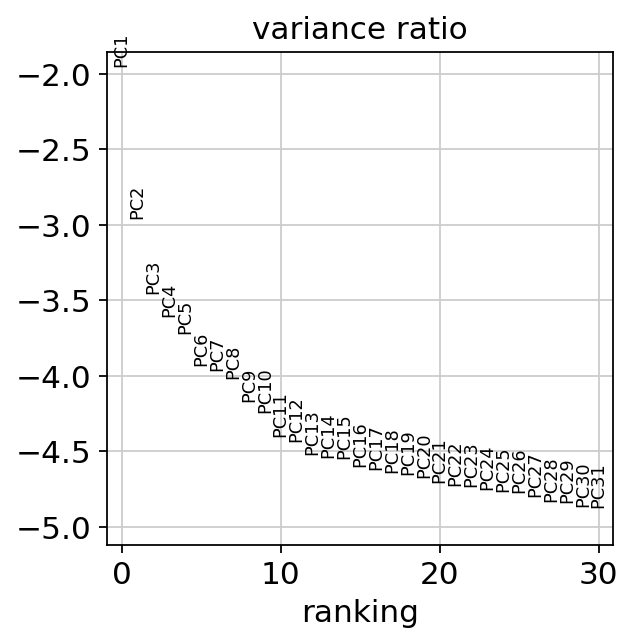

In [88]:
sc.pl.pca_variance_ratio(ecs, log=True)
sc.pl.pca_variance_ratio(mcs, log=True)

### Save

In [89]:
ecs.write("files/5_naive/ecs.h5ad")
mcs.write("files/5_naive/mcs.h5ad")

## UMAP and neighbour graph

In [91]:
sc.pp.neighbors(ecs, n_neighbors=10, n_pcs=40)
sc.pp.neighbors(mcs, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [92]:
sc.tl.umap(ecs)
sc.tl.umap(mcs)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


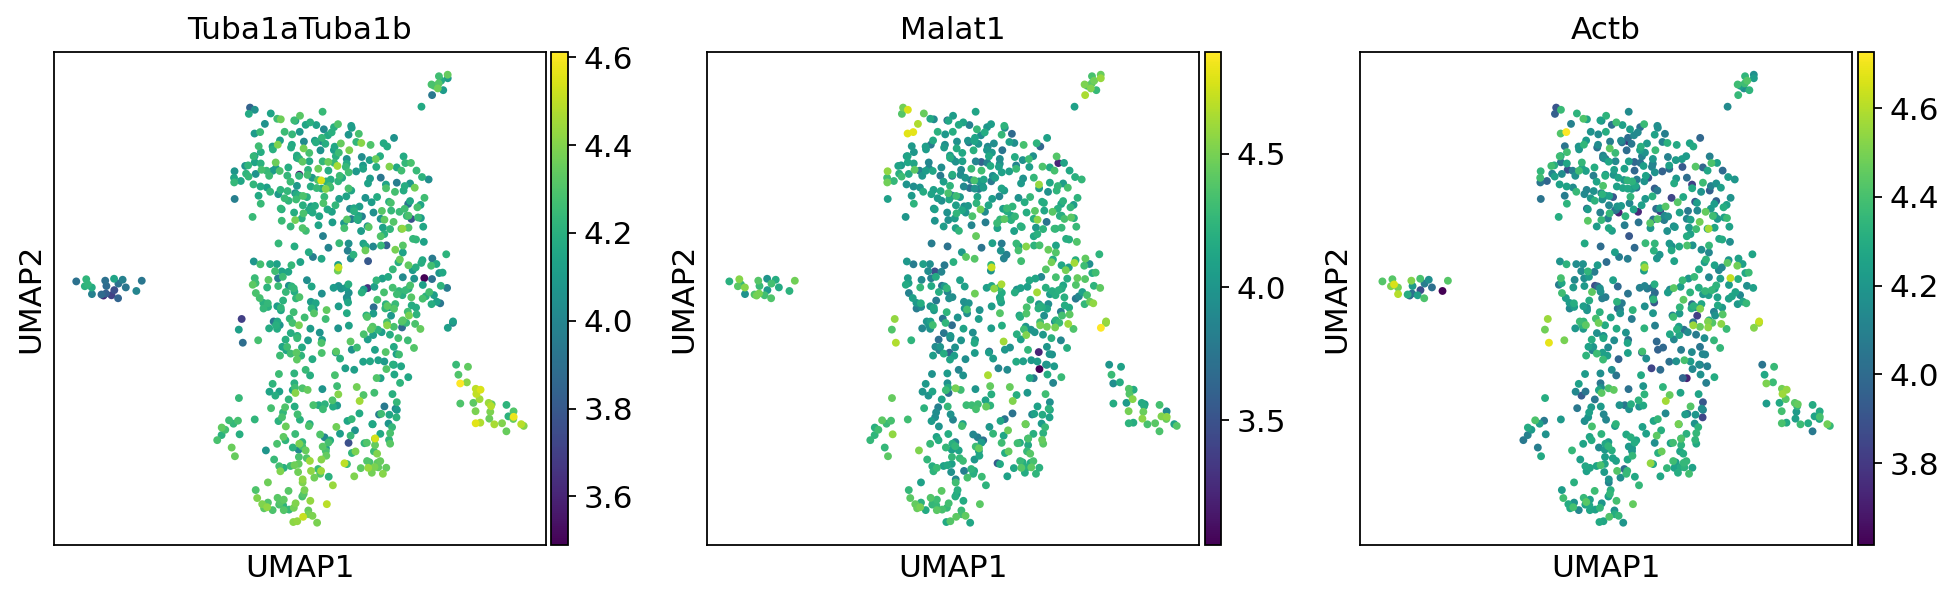

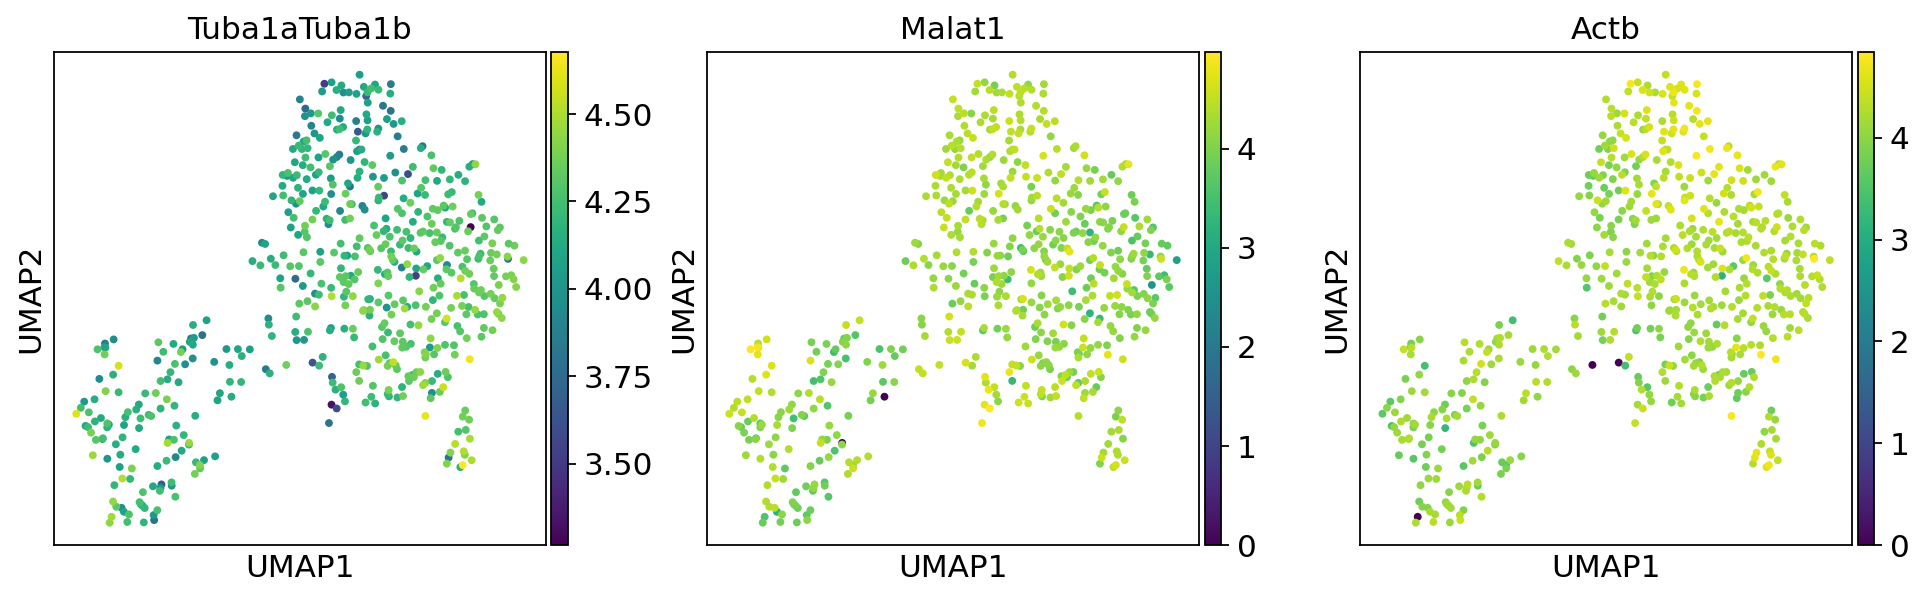

In [93]:
sc.pl.umap(ecs, color=["Tuba1aTuba1b", "Malat1", "Actb"], size=50)
sc.pl.umap(mcs, color=["Tuba1aTuba1b", "Malat1", "Actb"], size=50)

This is not fantastic seperation... Let's compute the leiden clusters and see if it looks any better

In [94]:
sc.tl.leiden(ecs)
sc.tl.leiden(mcs)

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


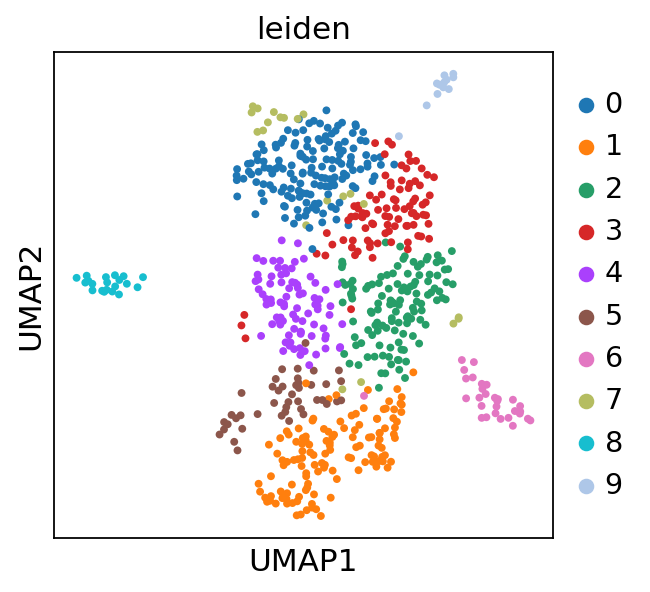

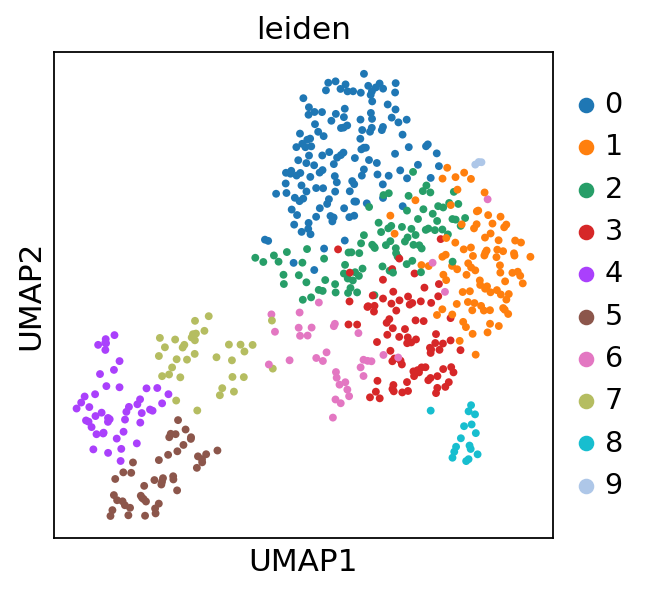

In [95]:
sc.pl.umap(ecs, color=["leiden",], size=50)
sc.pl.umap(mcs, color=["leiden",], size=50)

Ten clusters each, but we are not sure whether they correspond correctly to the same clusters in the Seurat analysis

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


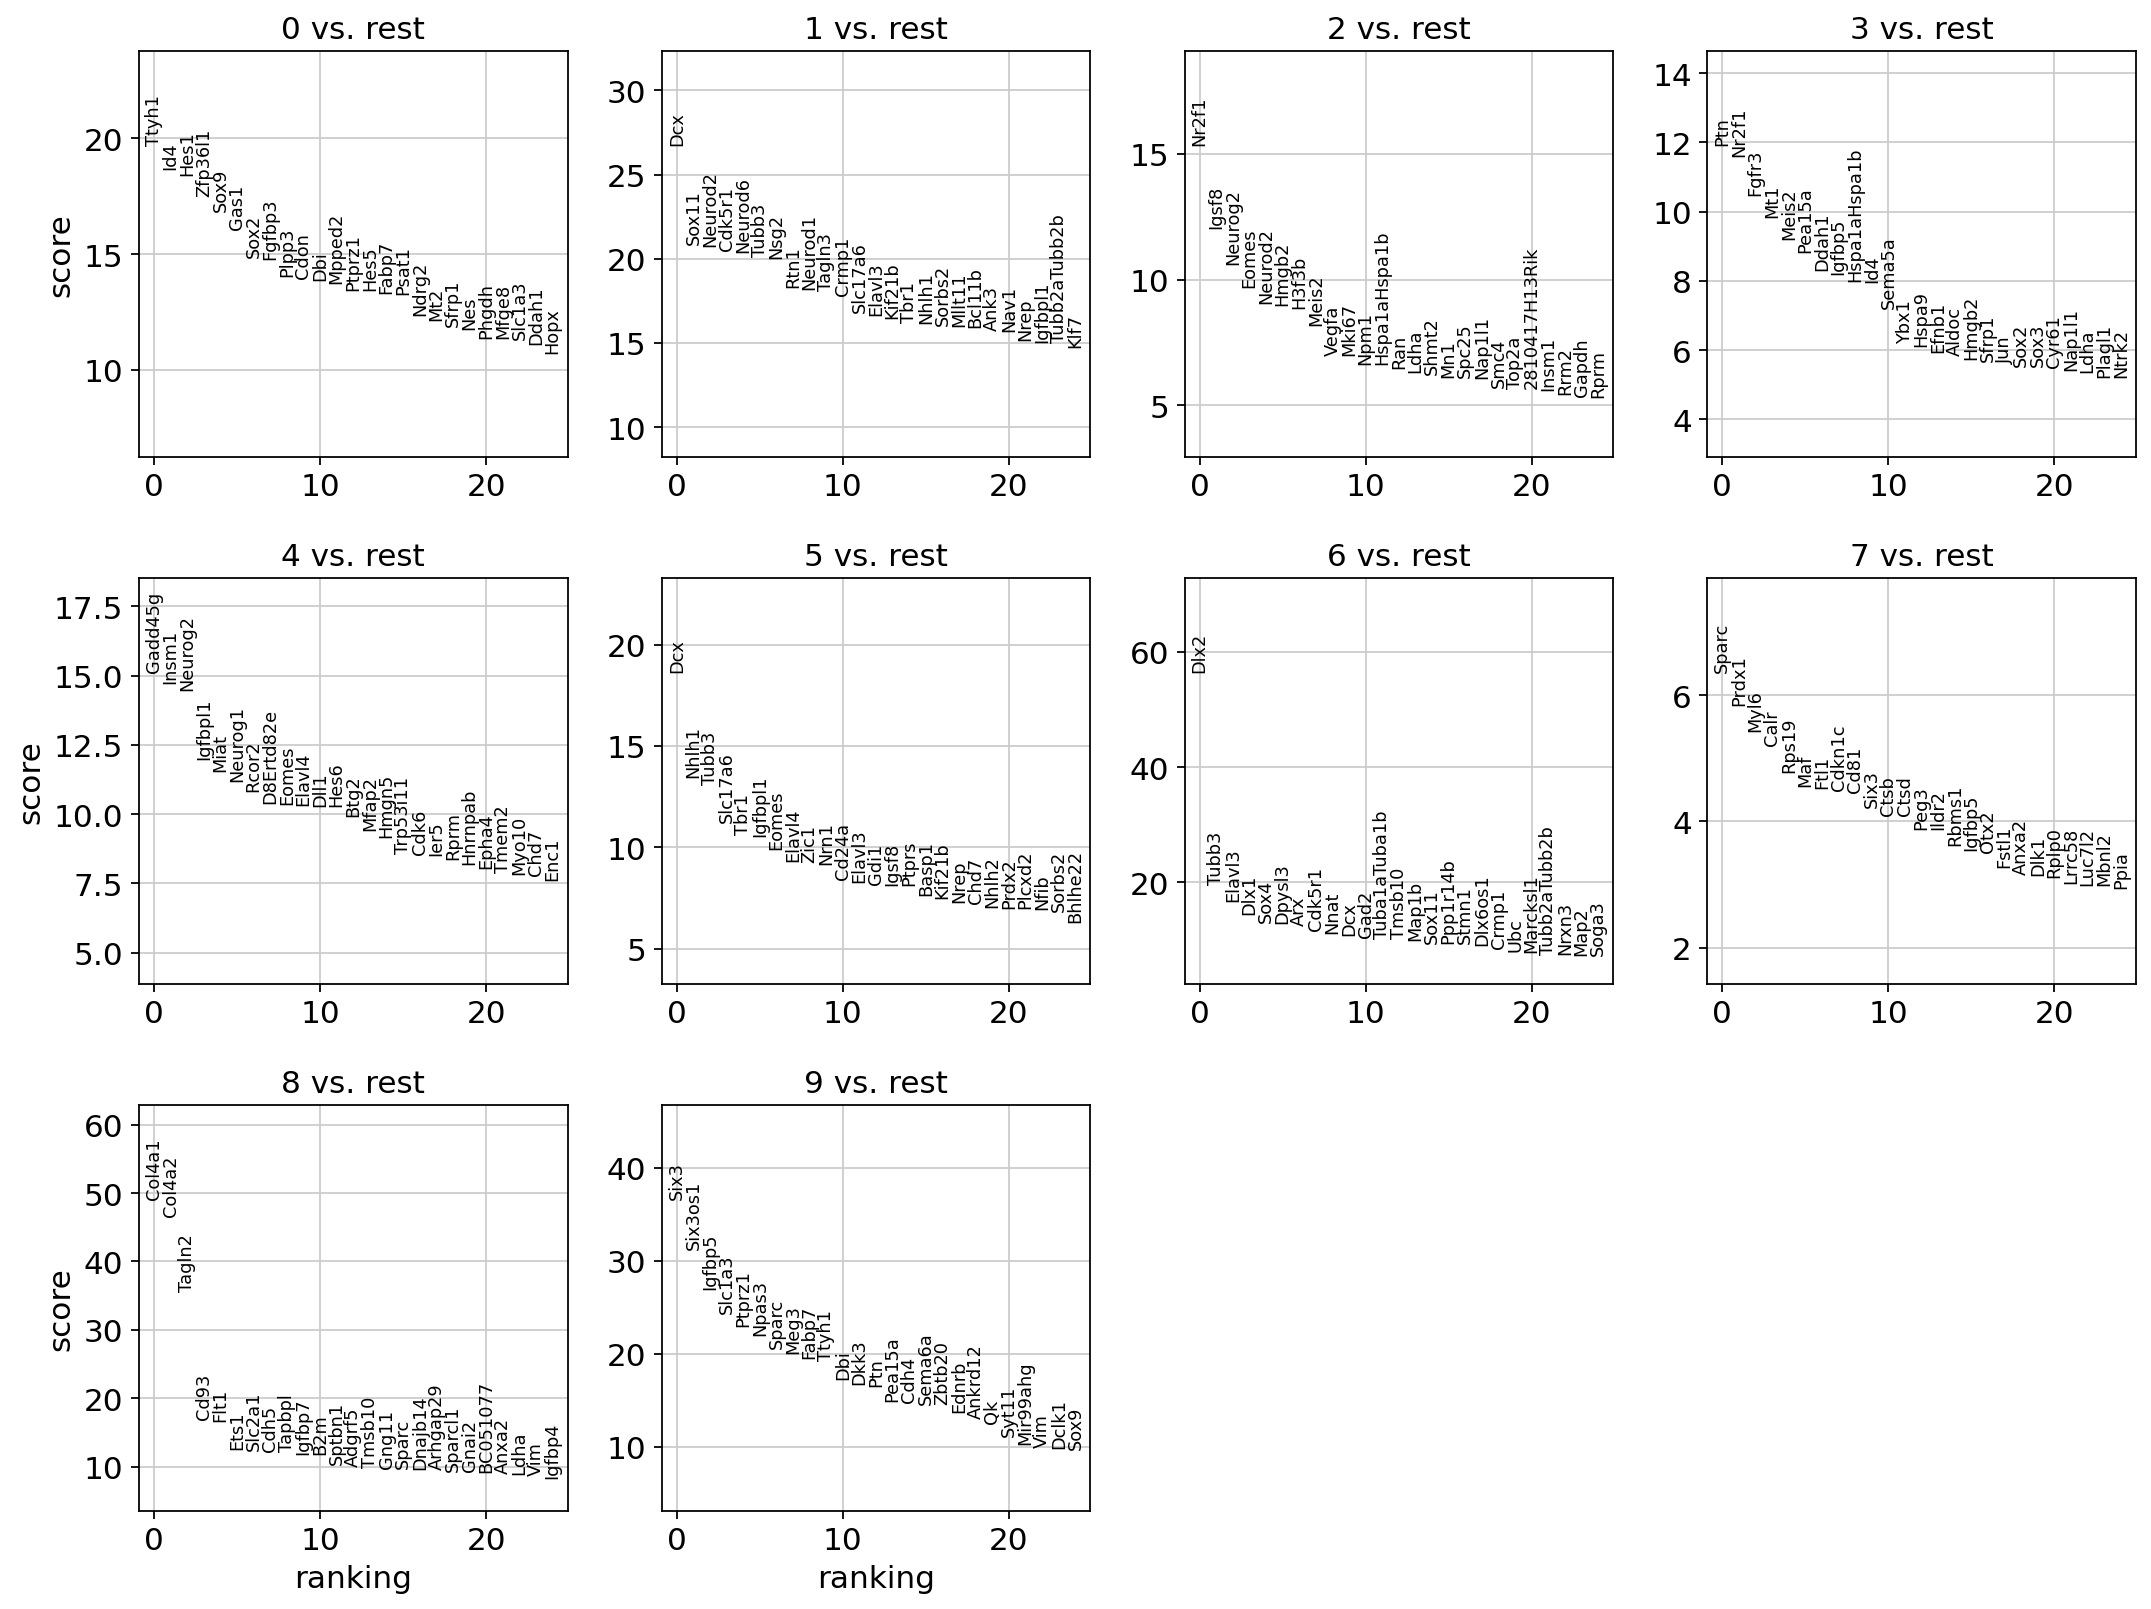

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


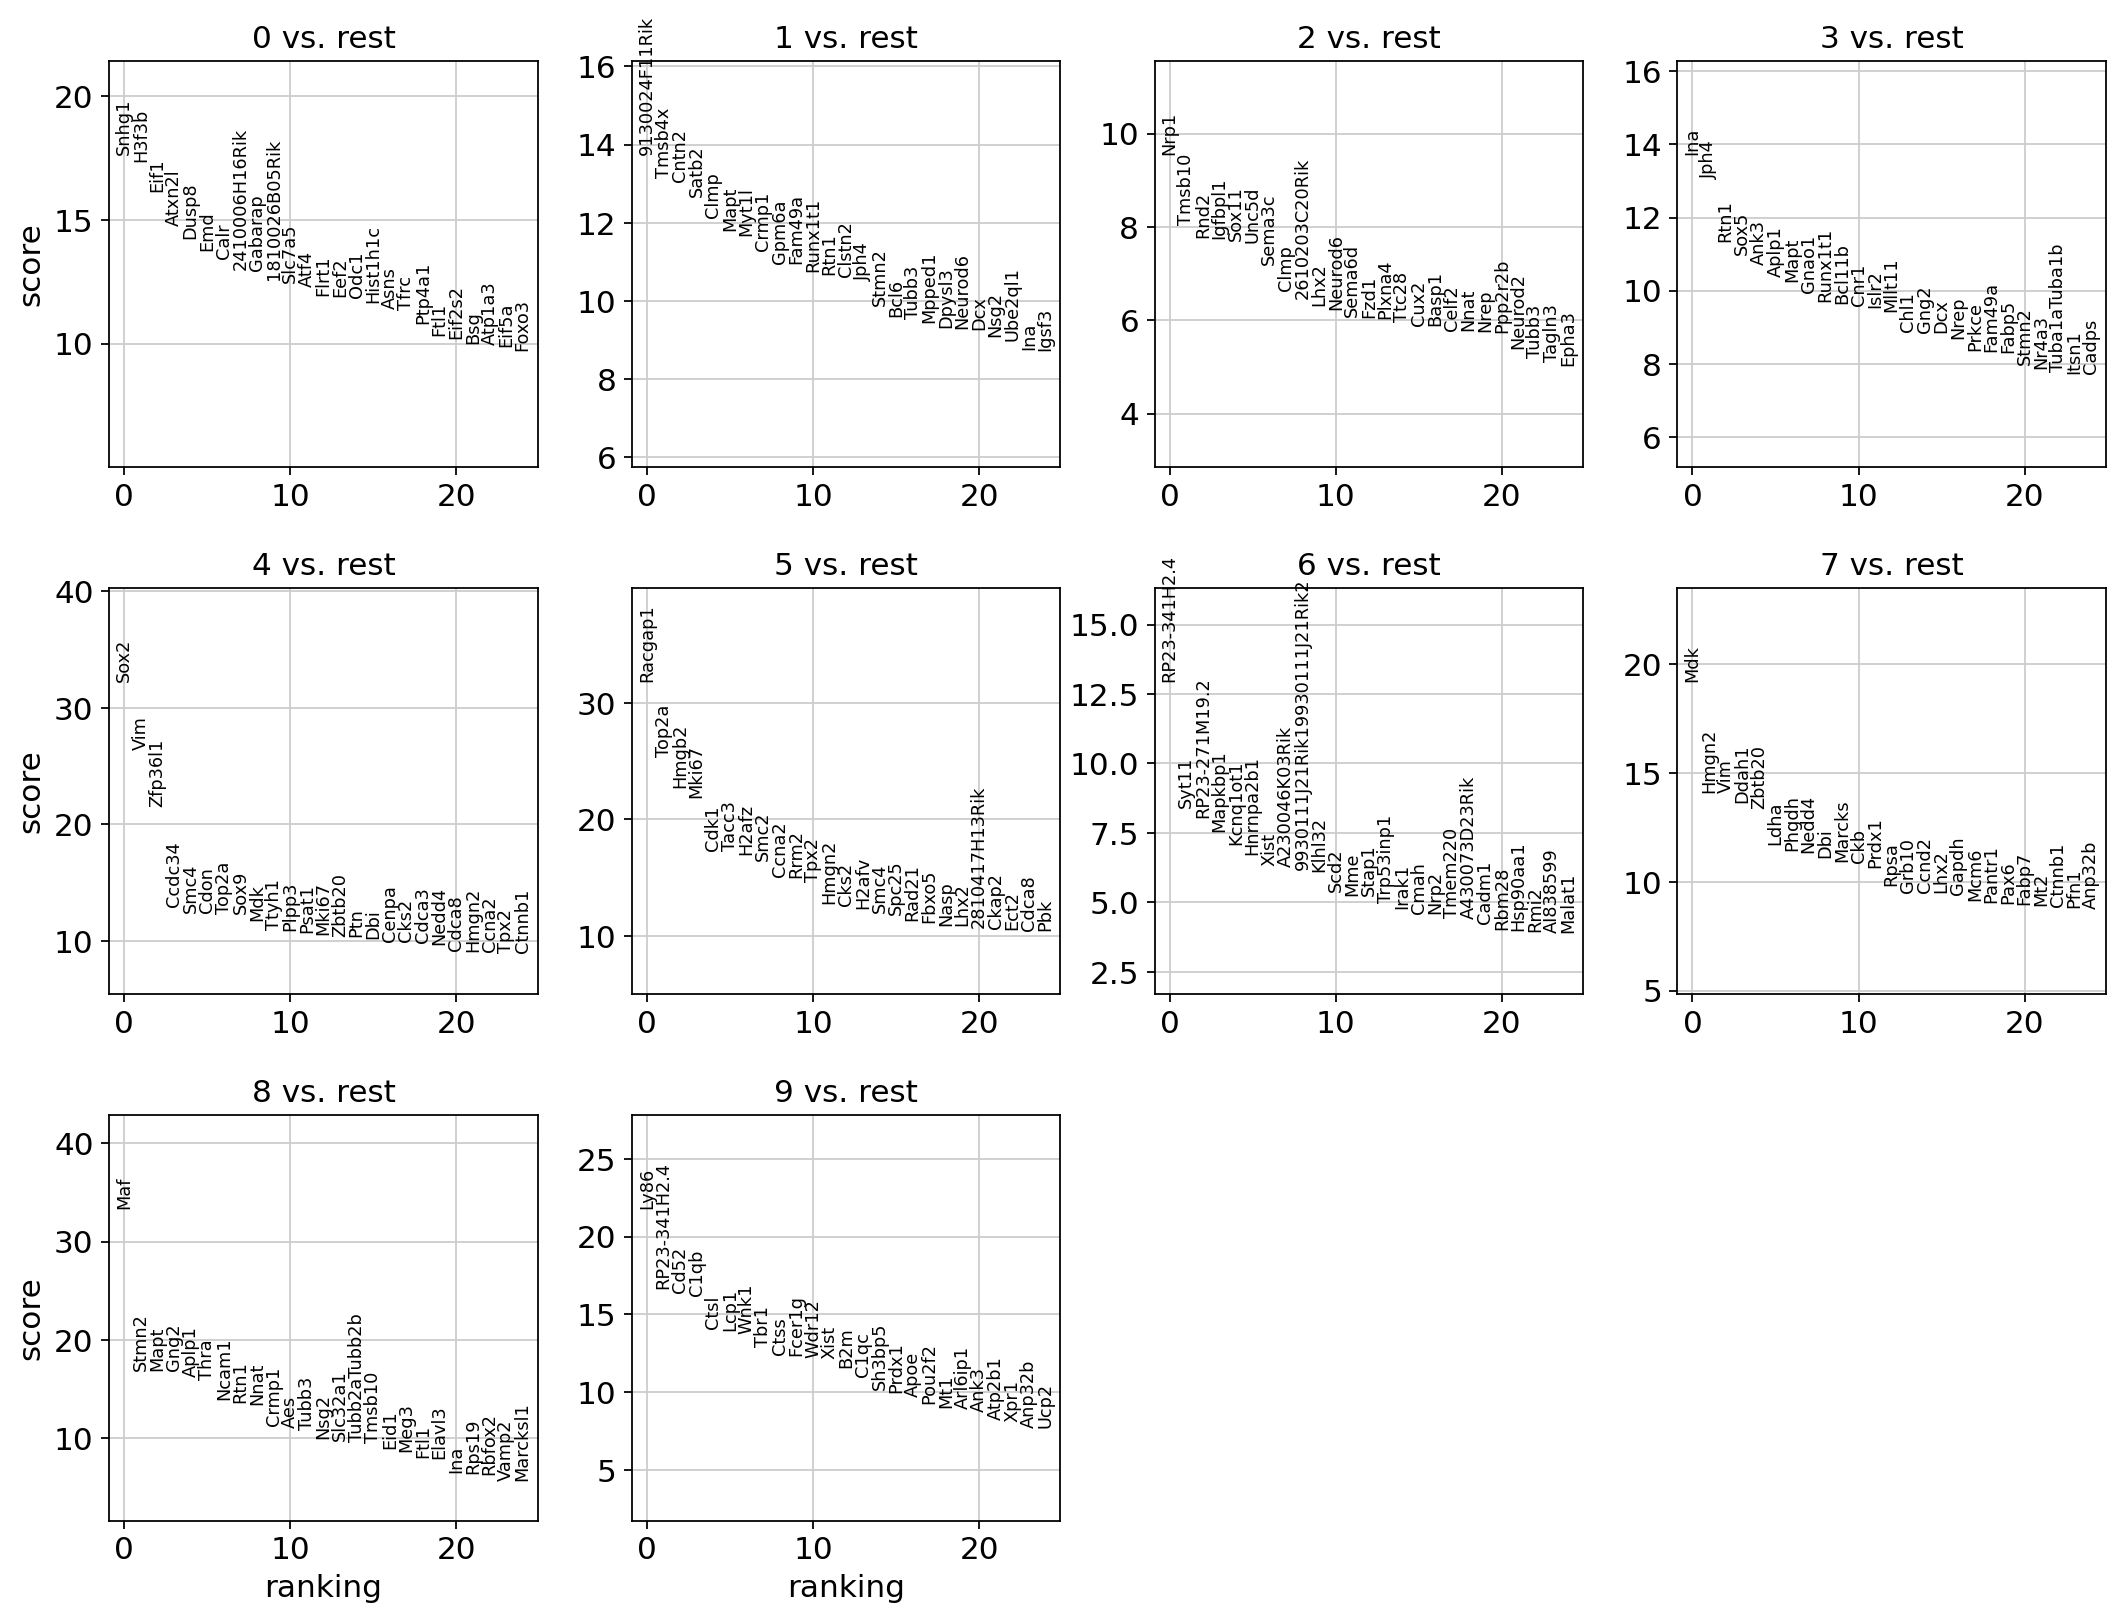

In [96]:
sc.tl.rank_genes_groups(ecs, 'leiden', method='t-test'); sc.pl.rank_genes_groups(ecs, n_genes=25, sharey=False)
sc.tl.rank_genes_groups(mcs, 'leiden', method='t-test'); sc.pl.rank_genes_groups(mcs, n_genes=25, sharey=False)

Nothing immediately jumps out at me. Let's compare them with the marker list that Bismark has

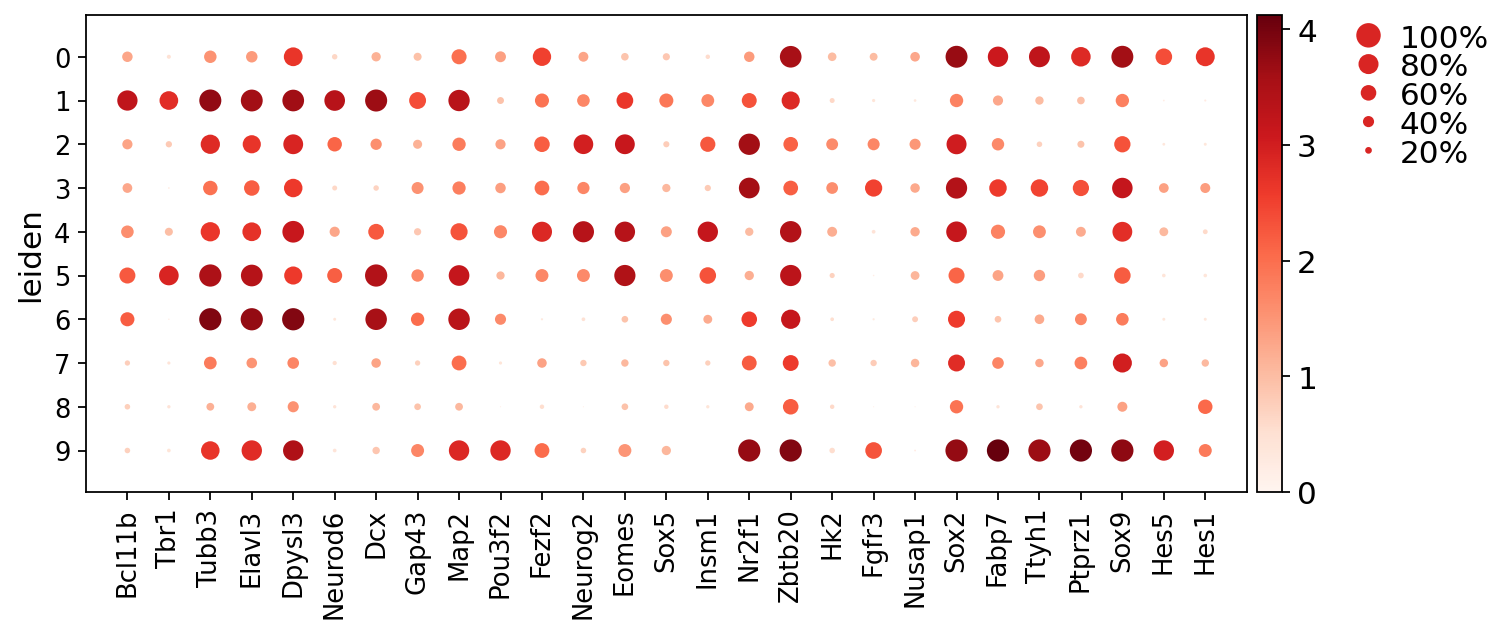

KeyError: "Values ['Fgfr3'], from ['Bcl11b', 'Tbr1', 'Tubb3', 'Elavl3', 'Dpysl3', 'Neurod6', 'Dcx', 'Gap43', 'Map2', 'Pou3f2', 'Fezf2', 'Neurog2', 'Eomes', 'Sox5', 'Insm1', 'Nr2f1', 'Zbtb20', 'Hk2', 'Fgfr3', 'Nusap1', 'Sox2', 'Fabp7', 'Ttyh1', 'Ptprz1', 'Sox9', 'Hes5', 'Hes1'], are not valid obs/ var names or indices."

In [97]:
bismark_genes = ("Bcl11b", "Tbr1", "Tubb3", "Elavl3", "Dpysl3", 
                 "Neurod6", "Dcx", "Gap43", "Map2", "Pou3f2", "Fezf2",
                 "Neurog2", "Eomes", "Sox5", "Insm1", "Nr2f1", "Zbtb20",
                 "Hk2", "Fgfr3", "Nusap1", "Sox2", "Fabp7", "Ttyh1", "Ptprz1",
                 "Sox9", "Hes5", "Hes1")
sc.pl.dotplot(ecs, bismark_genes, groupby='leiden');
sc.pl.dotplot(mcs, bismark_genes, groupby='leiden');

No. Half the genes weren't even detected in the MCS.

# how to proceed

Let's first test to see how good our clusters were between the those detected by Seurat, and those by Scanpy. We can compare assignments by reading in the new data matrix.